<a href="https://colab.research.google.com/github/RohanNayak12/Clinical_trial_processor/blob/main/ScibertTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Dataset we have used to train the model is a modified verison of the original dataset, it contains 42000 entries, we have done so due to hardware constraints on ourside.

for the final version we intend to use the entire dataset!

In [ ]:
import pandas as pd
import csv
df = pd.read_csv('/content/reduced_df.csv')
df.head()

,NCT Number,Study Title,Study URL,Acronym,Study Status,Brief Summary,Study Results,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,Other Outcome Measures,Sex,Age,Phases,Start Date,Primary Completion Date,Completion Date
0,NCT02265133,Corneal Sensitivity in Patients With Sleep Apn...,https://clinicaltrials.gov/study/NCT02265133,NaN,COMPLETED,"This study is a prospective, single center cli...",NO,Sleep Apnea,NaN,"Corneal Sensitivity, To investigate whether di...",NaN,NaN,ALL,"ADULT, OLDER_ADULT",NaN,2015-07-17,2022-07-01,2024-08-20
1,NCT03508700,A 40-week Study to Evaluate TNX-102 SL 5.6 mg ...,https://clinicaltrials.gov/study/NCT03508700,P306,COMPLETED,Evaluate the long-term safety of TNX-102 SL 5....,NO,PTSD,DRUG: TNX-102 SL 5.6 mg,Evaluate the incidence of adverse events of TN...,Evaluate the proportion of patients with a CGI...,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,2018-04-19,2019-09-30,2019-09-30
2,NCT06630507,Measuring Change in Overcoming Implicit Biases...,https://clinicaltrials.gov/study/NCT06630507,NaN,NOT_YET_RECRUITING,Implicit bias is a form of bias in which a per...,NO,Implicit Bias,BEHAVIORAL: Educational module,Examine emergency care center (ECC) staff's wi...,NaN,NaN,ALL,"ADULT, OLDER_ADULT",NaN,2024-11-01,2026-11-01,2026-11-01
3,NCT04768322,LVAD Versus GDMT in Ambulatory Advanced Heart ...,https://clinicaltrials.gov/study/NCT04768322,AMBU-VAD,RECRUITING,Heart failure is a severe disease affecting ap...,NO,End-stage Heart Failure,DEVICE: HeartMate 3 TM Left Ventricular Assist...,"All-cause mortality rate, The composite of 5 c...","Number of adverse events (AEs), at 1 month|Num...",NaN,ALL,"ADULT, OLDER_ADULT",NaN,2021-02-24,2029-02,2029-02
4,NCT00005605,Tamoxifen to Prevent Bone Loss and Heart Disea...,https://clinicaltrials.gov/study/NCT00005605,NaN,COMPLETED,RATIONALE: Tamoxifen may be able to increase b...,NO,Breast Cancer|Osteoporosis,NaN,NaN,NaN,NaN,FEMALE,ADULT,NaN,2000-02,2005-10,2005-10


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Dict, Tuple, Union
import logging
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import nltk
import pickle
nltk.download('punkt_tab')

class ClinicalTrialPreprocessor:
    def __init__(self):
        """
        Initialize the preprocessor with necessary NLTK resources.
        """
        try:
            import nltk
            nltk.download('punkt', quiet=True)
            nltk.download('stopwords', quiet=True)
            nltk.download('wordnet', quiet=True)
        except Exception as e:
            logging.warning(f"Could not download NLTK resources: {e}")

        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

        # Adding clinical trial specific stop words
        self.clinical_stop_words = {
            'study', 'trial', 'clinical', 'patient', 'patients', 'treatment',
            'week', 'weeks', 'month', 'months', 'year', 'years', 'day', 'days',
            'inclusion', 'exclusion', 'criteria', 'primary', 'secondary',
            'outcome', 'measure', 'endpoint', 'phase'
        }
        self.stop_words.update(self.clinical_stop_words)

        # Common medical abbreviations and their expansions
        self.medical_abbreviations = {
            'pt': 'patient',
            'pts': 'patients',
            'tx': 'treatment',
            'dx': 'diagnosis',
            'sx': 'symptoms',
            'hx': 'history',
            'labs': 'laboratory tests',
            'vs': 'vital signs',
            'bid': 'twice daily',
            'tid': 'three times daily',
            'qd': 'once daily',
            'prn': 'as needed',
            'yo': 'years old'
        }

    def standardize_units(self, text: str) -> str:
        """
        Standardize units and measurements in the text.
        """
        # Standardizing different unit representations
        unit_patterns = {
            r'(\d+)\s*(?:years?|yrs?|y\/o|yo)\s*(?:old|of age)?': r'\1 years',
            r'(\d+)\s*(?:weeks?|wks?)': r'\1 weeks',
            r'(\d+)\s*(?:days?|d)': r'\1 days',
            r'(\d+)\s*(?:months?|mos?)': r'\1 months',
            r'(\d+)\s*(?:mg\/dl|mg\/dL)': r'\1 mg/dL',
            r'(\d+)\s*(?:kg\/m2|kg\/m²)': r'\1 kg/m2',
            r'(\d+)\s*(?:mmHg)': r'\1 mmHg',
            r'(\d+)\s*(?:celsius|centigrade|°C)': r'\1 celsius',
            r'(\d+)\s*(?:milliliters?|mls?|mL)': r'\1 mL',
        }

        for pattern, replacement in unit_patterns.items():
            text = re.sub(pattern, replacement, text)
        return text

    def standardize_ranges(self, text: str) -> str:
        """
        Standardize numeric ranges in the text.
        """
        # Converting various range formats to standard format
        range_patterns = {
            r'(\d+)\s*-\s*(\d+)': r'\1 to \2',
            r'(\d+)\s*to\s*(\d+)': r'\1 to \2',
            r'between\s*(\d+)\s*and\s*(\d+)': r'\1 to \2',
            r'(\d+)\s*or\s*more': r'≥\1',
            r'(\d+)\s*or\s*greater': r'≥\1',
            r'greater\s*than\s*(\d+)': r'>\1',
            r'less\s*than\s*(\d+)': r'<\1',
        }

        for pattern, replacement in range_patterns.items():
            text = re.sub(pattern, replacement, text)
        return text

    def clean_text(self, text: str) -> str:
        """
        Basic text cleaning operations.
        """
        # Converting to lowercase
        text = text.lower()

        # Removing special characters but keep essential medical symbols
        text = re.sub(r'[^a-zA-Z0-9\s\-\/°±><≥≤=%\.]', ' ', text)

        # Removing extra whitespace
        text = ' '.join(text.split())

        return text

    def expand_abbreviations(self, text: str) -> str:
        """
        Expand common medical abbreviations.
        """
        words = text.split()
        expanded_words = [self.medical_abbreviations.get(word.lower(), word) for word in words]
        return ' '.join(expanded_words)

    def process_text(self, text: str, remove_stopwords: bool = True) -> str:
        """
        Complete text preprocessing pipeline.
        """
        text = self.clean_text(text)

        # Standardizing units and ranges
        text = self.standardize_units(text)
        text = self.standardize_ranges(text)

        # Expanding abbreviations
        text = self.expand_abbreviations(text)

        # Tokenization
        tokens = word_tokenize(text)

        if remove_stopwords:
            tokens = [token for token in tokens if token.lower() not in self.stop_words]

        # Lemmatization
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        return ' '.join(tokens)


class ClinicalTrialSimilaritySearch:
    def __init__(self, model_name: str = "allenai/scibert_scivocab_uncased"):
        """
        Initialize the similarity search system with SciBERT model.
        """
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.eval()
        self.embeddings = None
        self.trials_data = None
        self.preprocessor = ClinicalTrialPreprocessor()

    def get_bert_embedding(self, text: str) -> np.ndarray:
        """
        Generate BERT embeddings for the input text.

        Args:
            text: Input text to embed

        Returns:
            Numpy array containing text embedding
        """
        try:
            # Tokenizing and preparing input
            inputs = self.tokenizer(
                text,
                return_tensors="pt",
                max_length=512,
                truncation=True,
                padding=True
            )

            # Generating embeddings
            with torch.no_grad():
                outputs = self.model(**inputs)

            # Getting token embedding
            embedding = outputs.last_hidden_state[:, 0, :].numpy()
            return embedding

        except Exception as e:
            logging.error(f"Error generating embedding: {str(e)}")
            raise

    def preprocess_text(self, trial_data: Union[Dict[str, str], pd.Series]) -> str:
        """
        Preprocess and combine different fields of a clinical trial.
        """
        processed_fields = []

        if isinstance(trial_data, pd.Series):
            trial_data = trial_data.to_dict()

        fields = {
            'title': trial_data.get('Study Title', ''),
            'primary_outcome': trial_data.get('primary_outcome', ''),
            'secondary_outcome': trial_data.get('secondary_outcome', ''),
            'criteria': trial_data.get('criteria', '')
        }

        for field_name, field_value in fields.items():
            if field_value and not pd.isna(field_value):
                processed_text = self.preprocessor.process_text(
                    str(field_value),
                    remove_stopwords=(field_name != 'Study Title')
                )
                processed_fields.append(processed_text)

        return ' [SEP] '.join(processed_fields)

    def process_dataset(self, trials_data: Union[pd.DataFrame, List[Dict[str, str]]]):
        """
        Process the entire dataset and generate embeddings.
        """
        if isinstance(trials_data, list):
            trials_data = pd.DataFrame(trials_data)

        self.trials_data = trials_data
        embeddings = []

        print("Processing trials and generating embeddings...")
        total_trials = len(trials_data)

        for idx, row in self.trials_data.iterrows():
            if idx % 10 == 0:
                print(f"Processing trial {idx + 1}/{total_trials}")
            processed_text = self.preprocess_text(row)
            embedding = self.get_bert_embedding(processed_text)
            embeddings.append(embedding)

        self.embeddings = np.vstack(embeddings)
        print("Embedding generation complete!")

    def find_similar_trials(self,
                          trial_idx: int,
                          n_similar: int = 10) -> List[Tuple[int, float]]:
        """
        Find similar trials for a given trial index.
        """
        if self.embeddings is None:
            raise ValueError("Dataset not processed. Call process_dataset first.")

        if trial_idx >= len(self.embeddings):
            raise ValueError(f"Trial index {trial_idx} is out of bounds. Dataset has {len(self.embeddings)} trials.")

        query_embedding = self.embeddings[trial_idx]

        # Calculating cosine similarity
        similarities = cosine_similarity(query_embedding.reshape(1, -1),
                                      self.embeddings)[0]

        # Getting top similar trials (excluding the query trial itself)
        n_similar = min(n_similar, len(similarities) - 1)
        similar_indices = np.argsort(similarities)[::-1][1:n_similar+1]
        similar_scores = similarities[similar_indices]

        return list(zip(similar_indices, similar_scores))

    def get_all_similar_trials(self, n_similar: int = 10) -> Dict[int, List[Tuple[int, float]]]:
        """
        Generate similarity results for all trials in the dataset.
        """
        results = {}
        total_trials = len(self.trials_data)
        print(f"Finding similar trials for all {total_trials} trials...")

        for i in range(total_trials):
            if i % 10 == 0:
                print(f"Processing trial {i + 1}/{total_trials}")
            try:
                results[i] = self.find_similar_trials(i, n_similar)
            except Exception as e:
                logging.error(f"Error processing trial {i}: {str(e)}")

        print("Similarity search complete!")
        return results

# Example usage
def main():
    # Example DataFrame creation
    data = {
        'Study Title': ["tDCS Effect on Psychotic Symptoms in DLB", "Brain Stimulation in DLB"],
        'primary_outcome': ["Change in psychotic factor", "Symptom improvement"],
        'secondary_outcome': ["NPI total score change", "Quality of life"],
        'criteria': ["Age > 60, DLB diagnosis", "Adults with DLB"]
    }

    similarity_search = ClinicalTrialSimilaritySearch()

    similarity_search.process_dataset(df)

    with open('clinical_trial_similarity_model.pkl', 'wb') as file:
       pickle.dump(similarity_search, file)

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Processing trials and generating embeddings...
Processing trial 1/52000


KeyboardInterrupt: 

**1. ClinicalTrialPreprocessor Class:**<br>
This class is responsible for preprocessing and cleaning the text data from clinical trials.<br>
It performs the following tasks:<br>
-Standardizes units and measurements (e.g., converting "mg/dl" to "mg/dL").<br>
-Standardizes numeric ranges (e.g., converting "10-20" to "10 to 20").<br>
-Performs basic text cleaning (e.g., removing special characters, expanding abbreviations).<br>
-Tokenizes the text, removes stopwords, and applies lemmatization.




**2. ClinicalTrialSimilaritySearch Class:**

This class is the main entry point for the clinical trial similarity search system.
It uses the *SciBERT model* to generate embeddings for the clinical trial text data.
The *process_dataset* method processes the entire dataset and generates the embeddings.
The *find_similar_trials* method finds the top similar trials for a given trial index.
The *get_all_similar_trials* method generates similarity results for all trials in the dataset.

In order to verify the results we got, first load the csv file and the model(adjust the path as needed), run the above code cell until the embeddings start to generate and then terminate the process, this is needed since that introduces functions we need next to the current instance. We also intent to fix this for the final version

In [ ]:
import pandas as pd
import pickle
with open('/content/clinical_trial_similarity_model.pkl', 'rb') as file:
       loaded_model = pickle.load(file)

new_data = {
           'Study Title': ["tDCS Effect on Psychotic Symptoms in DLB", "Brain Stimulation in DLB"],
           'primary_outcome': ["Change in psychotic factor", "Symptom improvement"],
           'secondary_outcome': ["NPI total score change", "Quality of life"],
           'criteria': ["Age > 60, DLB diagnosis", "Adults with DLB"]
       }
new_df = pd.DataFrame(new_data)
new_embeddings = []
for idx, row in new_df.iterrows():
       processed_text = loaded_model.preprocess_text(row)
       embedding = loaded_model.get_bert_embedding(processed_text)
       new_embeddings.append(embedding)
new_embeddings = np.vstack(new_embeddings)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(new_embeddings, loaded_model.embeddings)

for i, new_trial in enumerate(new_data['Study Title']):
       similar_indices = similarities[i].argsort()[::-1][1:11]
       print(f"\nSimilar trials for '{new_trial}':")
       for idx in similar_indices:
           similar_trial_title = loaded_model.trials_data.iloc[idx]['Study Title']
           similarity_score = similarities[i][idx]
           print(f"- '{similar_trial_title}': Similarity score {similarity_score:.3f}")


Similar trials for 'tDCS Effect on Psychotic Symptoms in DLB':
- 'Cognitive Effects of tDCS and tRNS in Schizophrenia': Similarity score 0.902
- 'Effect of Bupropion on Smoking Behavior in Smokers With Schizophrenia': Similarity score 0.902
- 'Switching From SSRI to Desvenlafaxine on Cognitive Functioning': Similarity score 0.901
- 'Study of Mood Effects of Varenicline (Chantix) in Depressed Outpatient Smokers': Similarity score 0.895
- 'Cognitive Deficits in Major Depressive Disorder and Bipolar Disorder, Depressed Type: Prevalence and Improvement With Treatment of Depressive Symptoms': Similarity score 0.895
- 'Efficacy of EMDR in the Treatment of Depression and Comorbid Anxiety': Similarity score 0.894
- 'Effects of rTMS on the Anxiety State of Older Patients With GAD': Similarity score 0.894
- 'Effects of COVID-19 Forced Isolation Context on Adolescents With and Without Somatic Symptom Disorder': Similarity score 0.893
- 'Longitudinal Long-term Study (10 Years) of the Sample of Fi

In [ ]:
embeddings = loaded_model.embeddings

In [ ]:
!pip install umap-learn

In [ ]:
import umap

reducer = umap.UMAP(n_components=2)
embedding_2d = reducer.fit_transform(embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


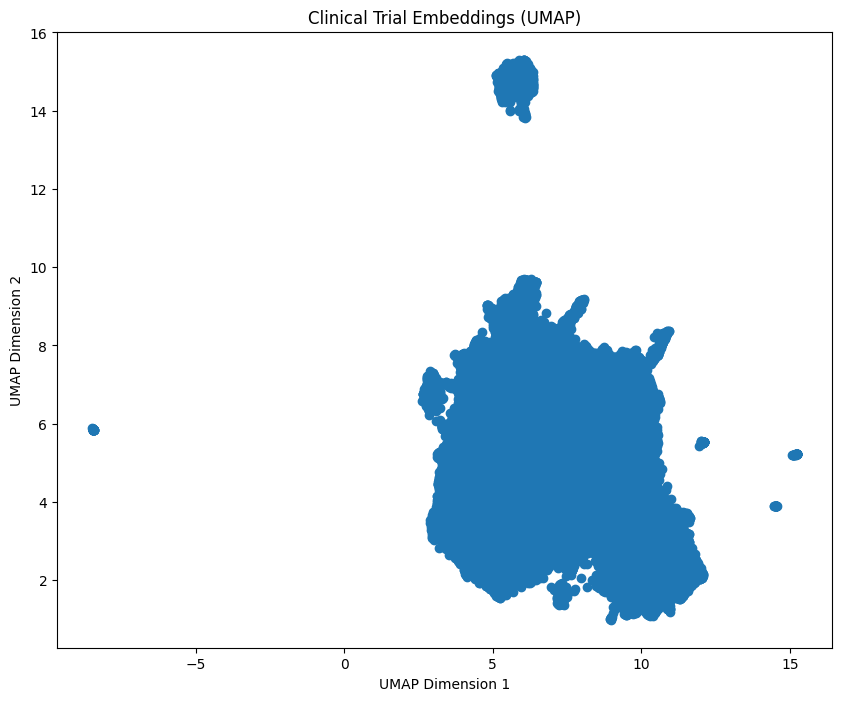

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1])
plt.title("Clinical Trial Embeddings (UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()
# Trials located near each other are likely to be more related in terms of their content and objectives.

In the above scatter plot, each data point represents a clinical trial, and the x-axis and y-axis correspond to the two dimensions of the UMAP projection. The scatter plot allows us to visualize the relationships and similarities between different clinical trials based on their embeddings.

The plot shows a cloud-like distribution of the clinical trial data points, with some clusters clearly visible. The size and shape of these clusters suggest that there are similarities and relationships between certain clinical trials.

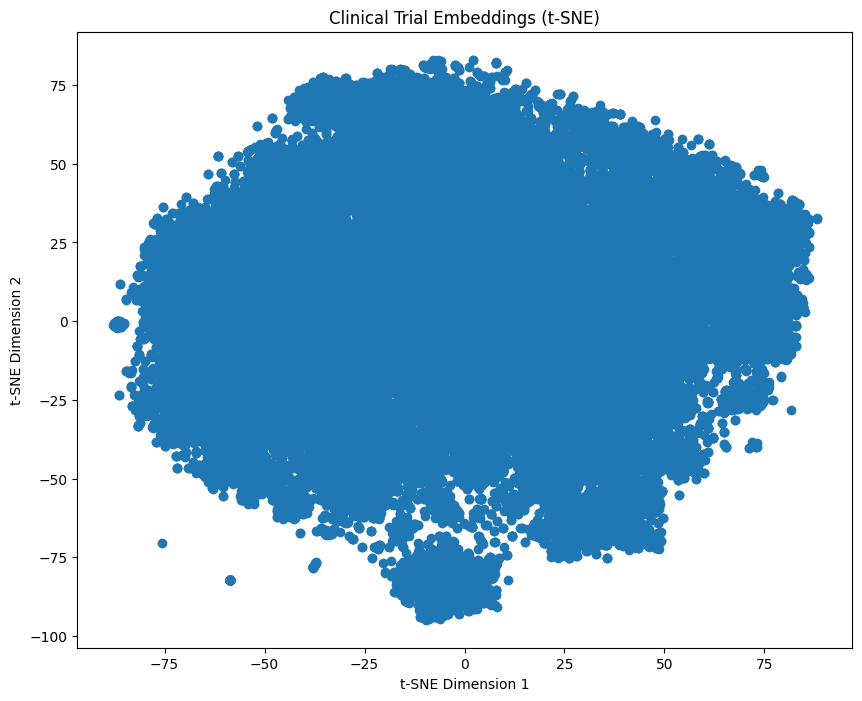

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = embeddings

# Applying t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title("Clinical Trial Embeddings (t-SNE)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

In this visualization, each data point represents a clinical trial, and the position of the points on the 2D plane reflects the similarity between the trials based on their embeddings. Trials that are closer together are more similar, while those farther apart are less similar.
The plot displays a cloud-like distribution of the data points, with some clear clusters visible. These clusters suggest that there are groups of similar clinical trials in the dataset. The scattered nature of the points indicates that the trials have diverse characteristics that have been captured in the t-SNE projection.